In [88]:
# Monitorization
import comet_ml
from comet_ml import start

import os

# Data
import numpy as np
import pandas as pd

# Audio
import librosa
import librosa.display

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

# Machine Learning
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, CSVLogger, ReduceLROnPlateau
from sklearn.utils import shuffle
import tensorflow.keras.backend as K

# Deep Learning Visualization
from sklearn.metrics import confusion_matrix

# Configurar el estilo de los gráficos
sns.set(style="ticks")

# Undestanding the Dataset

## Load Data

Data was loaded from the folders and it was made a dataframe that has been saved as a csv so it can directly be loaded from the CSV which contains each file path, the class and the duration of the segment. We will load the CSV directly:

In [89]:
# Load CSV
df_train = pd.read_csv('../../Dataset/CSVs/DatasetMultiLabel3Train.csv')
df_val = pd.read_csv('../../Dataset/CSVs/DatasetMultiLabel3Val.csv')
df_test = pd.read_csv('../../Dataset/CSVs/DatasetMultiLabel3Test.csv')

In [90]:
df_train.columns

Index(['Path', 'Segment', 'StartSecond', 'EndSecond', 'Breath1KHz', 'Whistle',
       'Golpe', 'Batida', 'BatidaClicks', 'BatidaClicksRapidaCascabel',
       'Toque', 'EmbarcacionLejana', 'EmbarcacionCercana', 'CLICK', 'UNKNOWN1',
       'UNKNOWN2200Hz', 'UNKNOWN3_BUBBLE_1kHz', 'UNKNOWN4_GOLPE_150Hz',
       'UNKNOWN5_INTERMITENTE', 'UNKNOWN6_PINPON', 'UNKNOWN7_EXPLOSION',
       'UNKNOWN8_OLEAJE', 'Class', 'NumClasses', 'SegmentPath', 'Subset'],
      dtype='object')

In [91]:
class_columns = [col for col in df_train.columns if col not in ['Path', 'Segment', 'StartSecond', 'EndSecond', 'Class', 'NumClasses', 'SegmentPath', 'Subset']]
len(class_columns)

18

In [92]:
import ast

# Convertir la columna 'Class' en una lista de clases
df_train['Class'] = df_train['Class'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df_val['Class'] = df_val['Class'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df_test['Class'] = df_test['Class'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

In [93]:
# Convert to sets of classes per subset
train_classes = set(df_train[class_columns].columns[df_train[class_columns].sum() > 0])  # Classes present in train set
val_classes = set(df_val[class_columns].columns[df_val[class_columns].sum() > 0])  # Classes present in validation set
test_classes = set(df_test[class_columns].columns[df_test[class_columns].sum() > 0])  # Classes present in test set

# classes = set train + val + test
CLASSES = train_classes.union(val_classes).union(test_classes)

# Display the number of classes in each set
print('Classes in Train set:', len(train_classes))
print('Classes in Validation set:', len(val_classes))
print('Classes in Test set:', len(test_classes))

# Find the differences between sets
print('Classes in Train set but not in Validation set:', train_classes - val_classes)
print('Classes in Train set but not in Test set:', train_classes - test_classes)
print('Classes in Validation set but not in Train set:', val_classes - train_classes)
print('Classes in Test set but not in Train set:', test_classes - train_classes)

# Total number of classes
print('Total classes:', len(CLASSES))

Classes in Train set: 18
Classes in Validation set: 12
Classes in Test set: 13
Classes in Train set but not in Validation set: {'UNKNOWN1', 'UNKNOWN6_PINPON', 'UNKNOWN8_OLEAJE', 'UNKNOWN5_INTERMITENTE', 'UNKNOWN2200Hz', 'UNKNOWN7_EXPLOSION'}
Classes in Train set but not in Test set: {'UNKNOWN1', 'UNKNOWN6_PINPON', 'BatidaClicksRapidaCascabel', 'UNKNOWN8_OLEAJE', 'UNKNOWN5_INTERMITENTE'}
Classes in Validation set but not in Train set: set()
Classes in Test set but not in Train set: set()
Total classes: 18


In [94]:
# Delete columns 'Breath1KHz', 'Whistle', 'Golpe', 'Batida', 'BatidaClicks', 'BatidaClicksRapidaCascabel', 'Toque', 'EmbarcacionLejana', 'EmbarcacionCercana', 'CLICK', 'UNKNOWN1', 'UNKNOWN2200Hz', 'UNKNOWN3_BUBBLE_1kHz', 'UNKNOWN4_GOLPE_150Hz', 'UNKNOWN5_INTERMITENTE', 'UNKNOWN6_PINPON', 'UNKNOWN7_EXPLOSION', 'UNKNOWN8_OLEAJE'
df_train = df_train.drop(columns=['Breath1KHz', 'Whistle', 'Golpe', 'Batida', 'BatidaClicks', 'BatidaClicksRapidaCascabel', 'Toque', 'EmbarcacionLejana', 'EmbarcacionCercana', 'CLICK', 'UNKNOWN1', 'UNKNOWN2200Hz', 'UNKNOWN3_BUBBLE_1kHz', 'UNKNOWN4_GOLPE_150Hz', 'UNKNOWN5_INTERMITENTE', 'UNKNOWN6_PINPON', 'UNKNOWN7_EXPLOSION', 'UNKNOWN8_OLEAJE'])
df_val = df_val.drop(columns=['Breath1KHz', 'Whistle', 'Golpe', 'Batida', 'BatidaClicks', 'BatidaClicksRapidaCascabel', 'Toque', 'EmbarcacionLejana', 'EmbarcacionCercana', 'CLICK', 'UNKNOWN1', 'UNKNOWN2200Hz', 'UNKNOWN3_BUBBLE_1kHz', 'UNKNOWN4_GOLPE_150Hz', 'UNKNOWN5_INTERMITENTE', 'UNKNOWN6_PINPON', 'UNKNOWN7_EXPLOSION', 'UNKNOWN8_OLEAJE'])
df_test = df_test.drop(columns=['Breath1KHz', 'Whistle', 'Golpe', 'Batida', 'BatidaClicks', 'BatidaClicksRapidaCascabel', 'Toque', 'EmbarcacionLejana', 'EmbarcacionCercana', 'CLICK', 'UNKNOWN1', 'UNKNOWN2200Hz', 'UNKNOWN3_BUBBLE_1kHz', 'UNKNOWN4_GOLPE_150Hz', 'UNKNOWN5_INTERMITENTE', 'UNKNOWN6_PINPON', 'UNKNOWN7_EXPLOSION', 'UNKNOWN8_OLEAJE'])

In [95]:
# Sort class_columns alphanumerically
class_columns_sorted = sorted(class_columns)

# Create classes_mapping: from class name to integer index
CLASSES_MAPPING = {class_name: index for index, class_name in enumerate(class_columns_sorted)}

# Create reverse_classes_mapping: from integer index to class name
REVERSE_CLASSES_MAPPING = {index: class_name for index, class_name in enumerate(class_columns_sorted)}

# Print the mappings to verify
print("Classes Mapping (Class -> Integer Index):")
print(CLASSES_MAPPING)
print("\nReverse Classes Mapping (Integer Index -> Class):")
print(REVERSE_CLASSES_MAPPING)

Classes Mapping (Class -> Integer Index):
{'Batida': 0, 'BatidaClicks': 1, 'BatidaClicksRapidaCascabel': 2, 'Breath1KHz': 3, 'CLICK': 4, 'EmbarcacionCercana': 5, 'EmbarcacionLejana': 6, 'Golpe': 7, 'Toque': 8, 'UNKNOWN1': 9, 'UNKNOWN2200Hz': 10, 'UNKNOWN3_BUBBLE_1kHz': 11, 'UNKNOWN4_GOLPE_150Hz': 12, 'UNKNOWN5_INTERMITENTE': 13, 'UNKNOWN6_PINPON': 14, 'UNKNOWN7_EXPLOSION': 15, 'UNKNOWN8_OLEAJE': 16, 'Whistle': 17}

Reverse Classes Mapping (Integer Index -> Class):
{0: 'Batida', 1: 'BatidaClicks', 2: 'BatidaClicksRapidaCascabel', 3: 'Breath1KHz', 4: 'CLICK', 5: 'EmbarcacionCercana', 6: 'EmbarcacionLejana', 7: 'Golpe', 8: 'Toque', 9: 'UNKNOWN1', 10: 'UNKNOWN2200Hz', 11: 'UNKNOWN3_BUBBLE_1kHz', 12: 'UNKNOWN4_GOLPE_150Hz', 13: 'UNKNOWN5_INTERMITENTE', 14: 'UNKNOWN6_PINPON', 15: 'UNKNOWN7_EXPLOSION', 16: 'UNKNOWN8_OLEAJE', 17: 'Whistle'}


In [96]:
from sklearn.preprocessing import MultiLabelBinarizer

y_train = df_train["Class"]

print("Labels:")
mlb = MultiLabelBinarizer()
mlb.fit(y_train)

# Loop over all labels and show them
N_LABELS = len(mlb.classes_)
for (i, label) in enumerate(mlb.classes_):
    print("{}. {}".format(i, label))

Labels:
0. Batida
1. BatidaClicks
2. BatidaClicksRapidaCascabel
3. Breath1KHz
4. CLICK
5. EmbarcacionCercana
6. EmbarcacionLejana
7. Golpe
8. Toque
9. UNKNOWN1
10. UNKNOWN2200Hz
11. UNKNOWN3_BUBBLE_1kHz
12. UNKNOWN4_GOLPE_150Hz
13. UNKNOWN5_INTERMITENTE
14. UNKNOWN6_PINPON
15. UNKNOWN7_EXPLOSION
16. UNKNOWN8_OLEAJE
17. Whistle


# Functions

In [97]:
def plot_results(df_results, reverse_classes_mapping=REVERSE_CLASSES_MAPPING, mode='random', classes=None):
    # If classes, select only specific classes
    if classes:
        df_results = df_results[df_results['PredictedClass'].isin(classes)]

    # Highest confidence
    if mode == 'max':
        # Select the 25 samples with the highest confidence
        samples = df_results.sort_values(by='Confidence', ascending=False).head(25)
    # Lowest confidence
    elif mode == 'min':
        # Select the 25 samples with the lowest confidence
        samples = df_results.sort_values(by='Confidence').head(25)
    # Random
    else: # mode == 'random':
        # Select 25 random samples
        samples = df_results.sample(25, random_state=42)

    # Create a grid of plots
    fig, axes = plt.subplots(5, 5, figsize=(20, 20))

    # Flatten the axes
    axes = axes.ravel()

    # Loop through all the samples
    for i, (_, row) in enumerate(samples.iterrows()):
        # Get the true and predicted labels
        true_label = reverse_classes_mapping[row['True']]
        pred_label = reverse_classes_mapping[row['Predicted']]
        confidence = row['Confidence']
        
        # Get the color of the label
        color = 'green' if true_label == pred_label else 'red'
        
        # Calculate the mel spectrogram
        mel_spectrogram = librosa.feature.melspectrogram(y=row['Signal'], sr=48000)
        mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
        
        # Plot the mel spectrogram
        axes[i].imshow(mel_spectrogram, origin='lower')
        axes[i].set_title(f"True: {true_label}\nPred: {pred_label} ({confidence:.2f})", color=color)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

## Preprocess Audios

As most audios are 3 seconds more or less, the time windows that will be used will be 3 seconds

Sampling rate was 256000 but BirdNET takes 48000, so 48000 will be used. It just changes the resolution of the audio.

Class: ['Breath1KHz', 'CLICK']


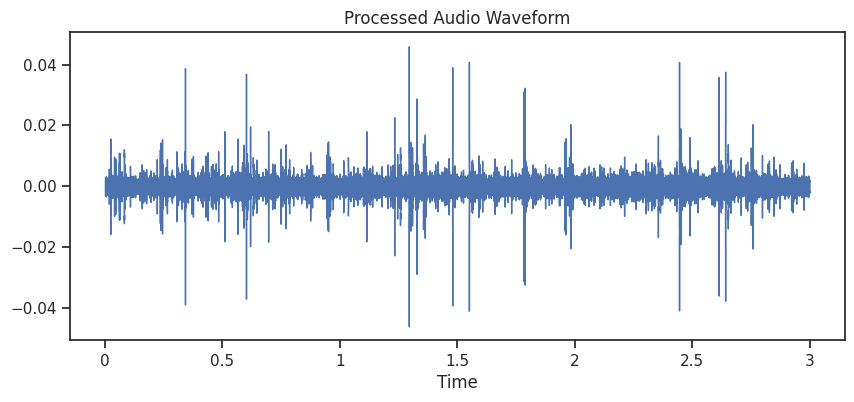

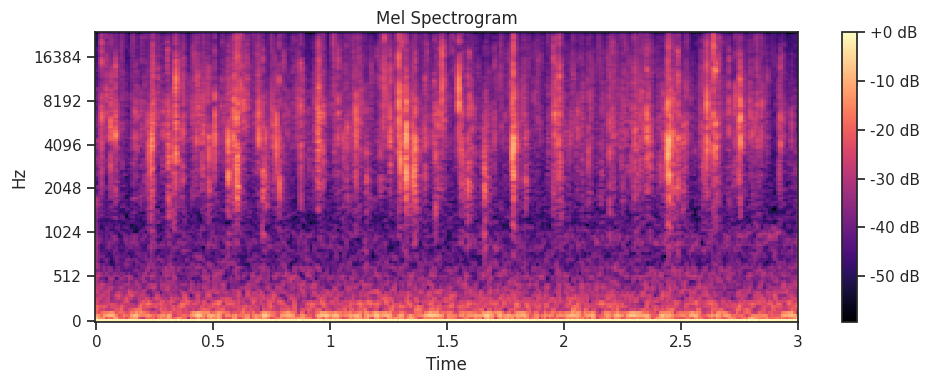

In [98]:
# Function to preprocess audio
def preprocess_audio(file_path, DatasetPath="", target_sr=48000, duration=3):
    # Load audio
    file_path = os.path.join(DatasetPath, file_path)
    signal, sr = librosa.load(file_path, sr=target_sr, mono=True)
    
    # Calculate the maximum length in samples
    max_length = target_sr * duration  # e.g., 48000 * 3
    
    # If the signal is shorter than the desired length, pad with silence
    if len(signal) < max_length:
        padding = max_length - len(signal)
        pad_left = padding // 2
        pad_right = padding - pad_left
        signal = np.pad(signal, (pad_left, pad_right), mode='constant')
        return signal
    
    # If the signal is longer than the desired length, split into 3-second windows
    elif len(signal) > max_length:
        # first cut the signal so it will split in multiples of 3
        signal = signal[:-(len(signal) % max_length)]
        segments = []
        for start in range(0, len(signal), max_length):
            end = start + max_length
            segment = signal[start:end]
            if len(segment) < max_length:
                segment = np.pad(segment, (0, max_length - len(segment)), mode='constant')
            if len(segment) >= target_sr:  # Ensure segment is at least 1 second long
                segments.append(segment)
        return segments
    
    # If the signal is exactly the desired length, return as is
    else:
        return signal

# Test preprocess on a single file
DatasetPath = '../../Dataset/Audios/SEANIMALMOVE/SegmentedAudiosMultiLabel3/'
sample_file = os.path.join(df_train["SegmentPath"][0])
processed_audios = preprocess_audio(sample_file, DatasetPath, target_sr=48000, duration=3)

# Visualize waveforms

# print class
print(f"Class: {df_train['Class'][1]}")

plt.figure(figsize=(10, 4))
librosa.display.waveshow(processed_audios, sr=48000)
plt.title(f"Processed Audio Waveform")
plt.show()

# Mel spectrogram
mel_spectrogram = librosa.feature.melspectrogram(y=processed_audios, sr=48000)
mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

# Visualize mel spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spectrogram, sr=48000, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title(f"Mel Spectrogram")
plt.tight_layout()
plt.show()

# Listen audio
import IPython.display as ipd
ipd.Audio(processed_audios, rate=48000)

In [99]:
df_train

Path  Segment  StartSecond  EndSecond  \
0      channelA_2024-05-27_23-59-24.wav        0            0          3   
1      channelA_2024-05-27_23-59-24.wav        1            3          6   
2      channelA_2024-05-27_23-59-24.wav        2            6          9   
3      channelA_2024-05-27_23-59-24.wav        3            9         12   
4      channelA_2024-05-27_23-59-24.wav        4           12         15   
...                                 ...      ...          ...        ...   
40219  channelA_2024-05-29_23-58-24.wav       15           45         48   
40220  channelA_2024-05-29_23-58-24.wav       16           48         51   
40221  channelA_2024-05-29_23-58-24.wav       17           51         54   
40222  channelA_2024-05-29_23-58-24.wav       18           54         57   
40223  channelA_2024-05-29_23-58-24.wav       19           57         60   

                     Class  NumClasses  \
0                       []           0   
1      [Breath1KHz, CLICK]           2   
2                       []           0   
3             [Breath1KHz]           1   
4      [Breath1KHz, CLICK]           2   
...                    ...         ...   
40219                   []           0   
40220                   []           0   
40221                   []           0   
40222                   []           0   
40223                   []           0   

                                  SegmentPath Subset  
0        channelA_2024-05-27_23-59-24_0_3.wav  train  
1        channelA_2024-05-27_23-59-24_3_6.wav  train  
2        channelA_2024-05-27_23-59-24_6_9.wav  train  
3       channelA_2024-05-27_23-59-24_9_12.wav  train  
4      channelA_2024-05-27_23-59-24_12_15.wav  train  
...                                       ...    ...  
40219  channelA_2024-05-29_23-58-24_45_48.wav  train  
40220  channelA_2024-05-29_23-58-24_48_51.wav  train  
40221  channelA_2024-05-29_23-58-24_51_54.wav  train  
40222  channelA_2024-05-29_23-58-24_54_57.wav  train  
40223  channelA_2024-05-29_23-58-24_57_60.wav  train  

[40224 rows x 8 columns]

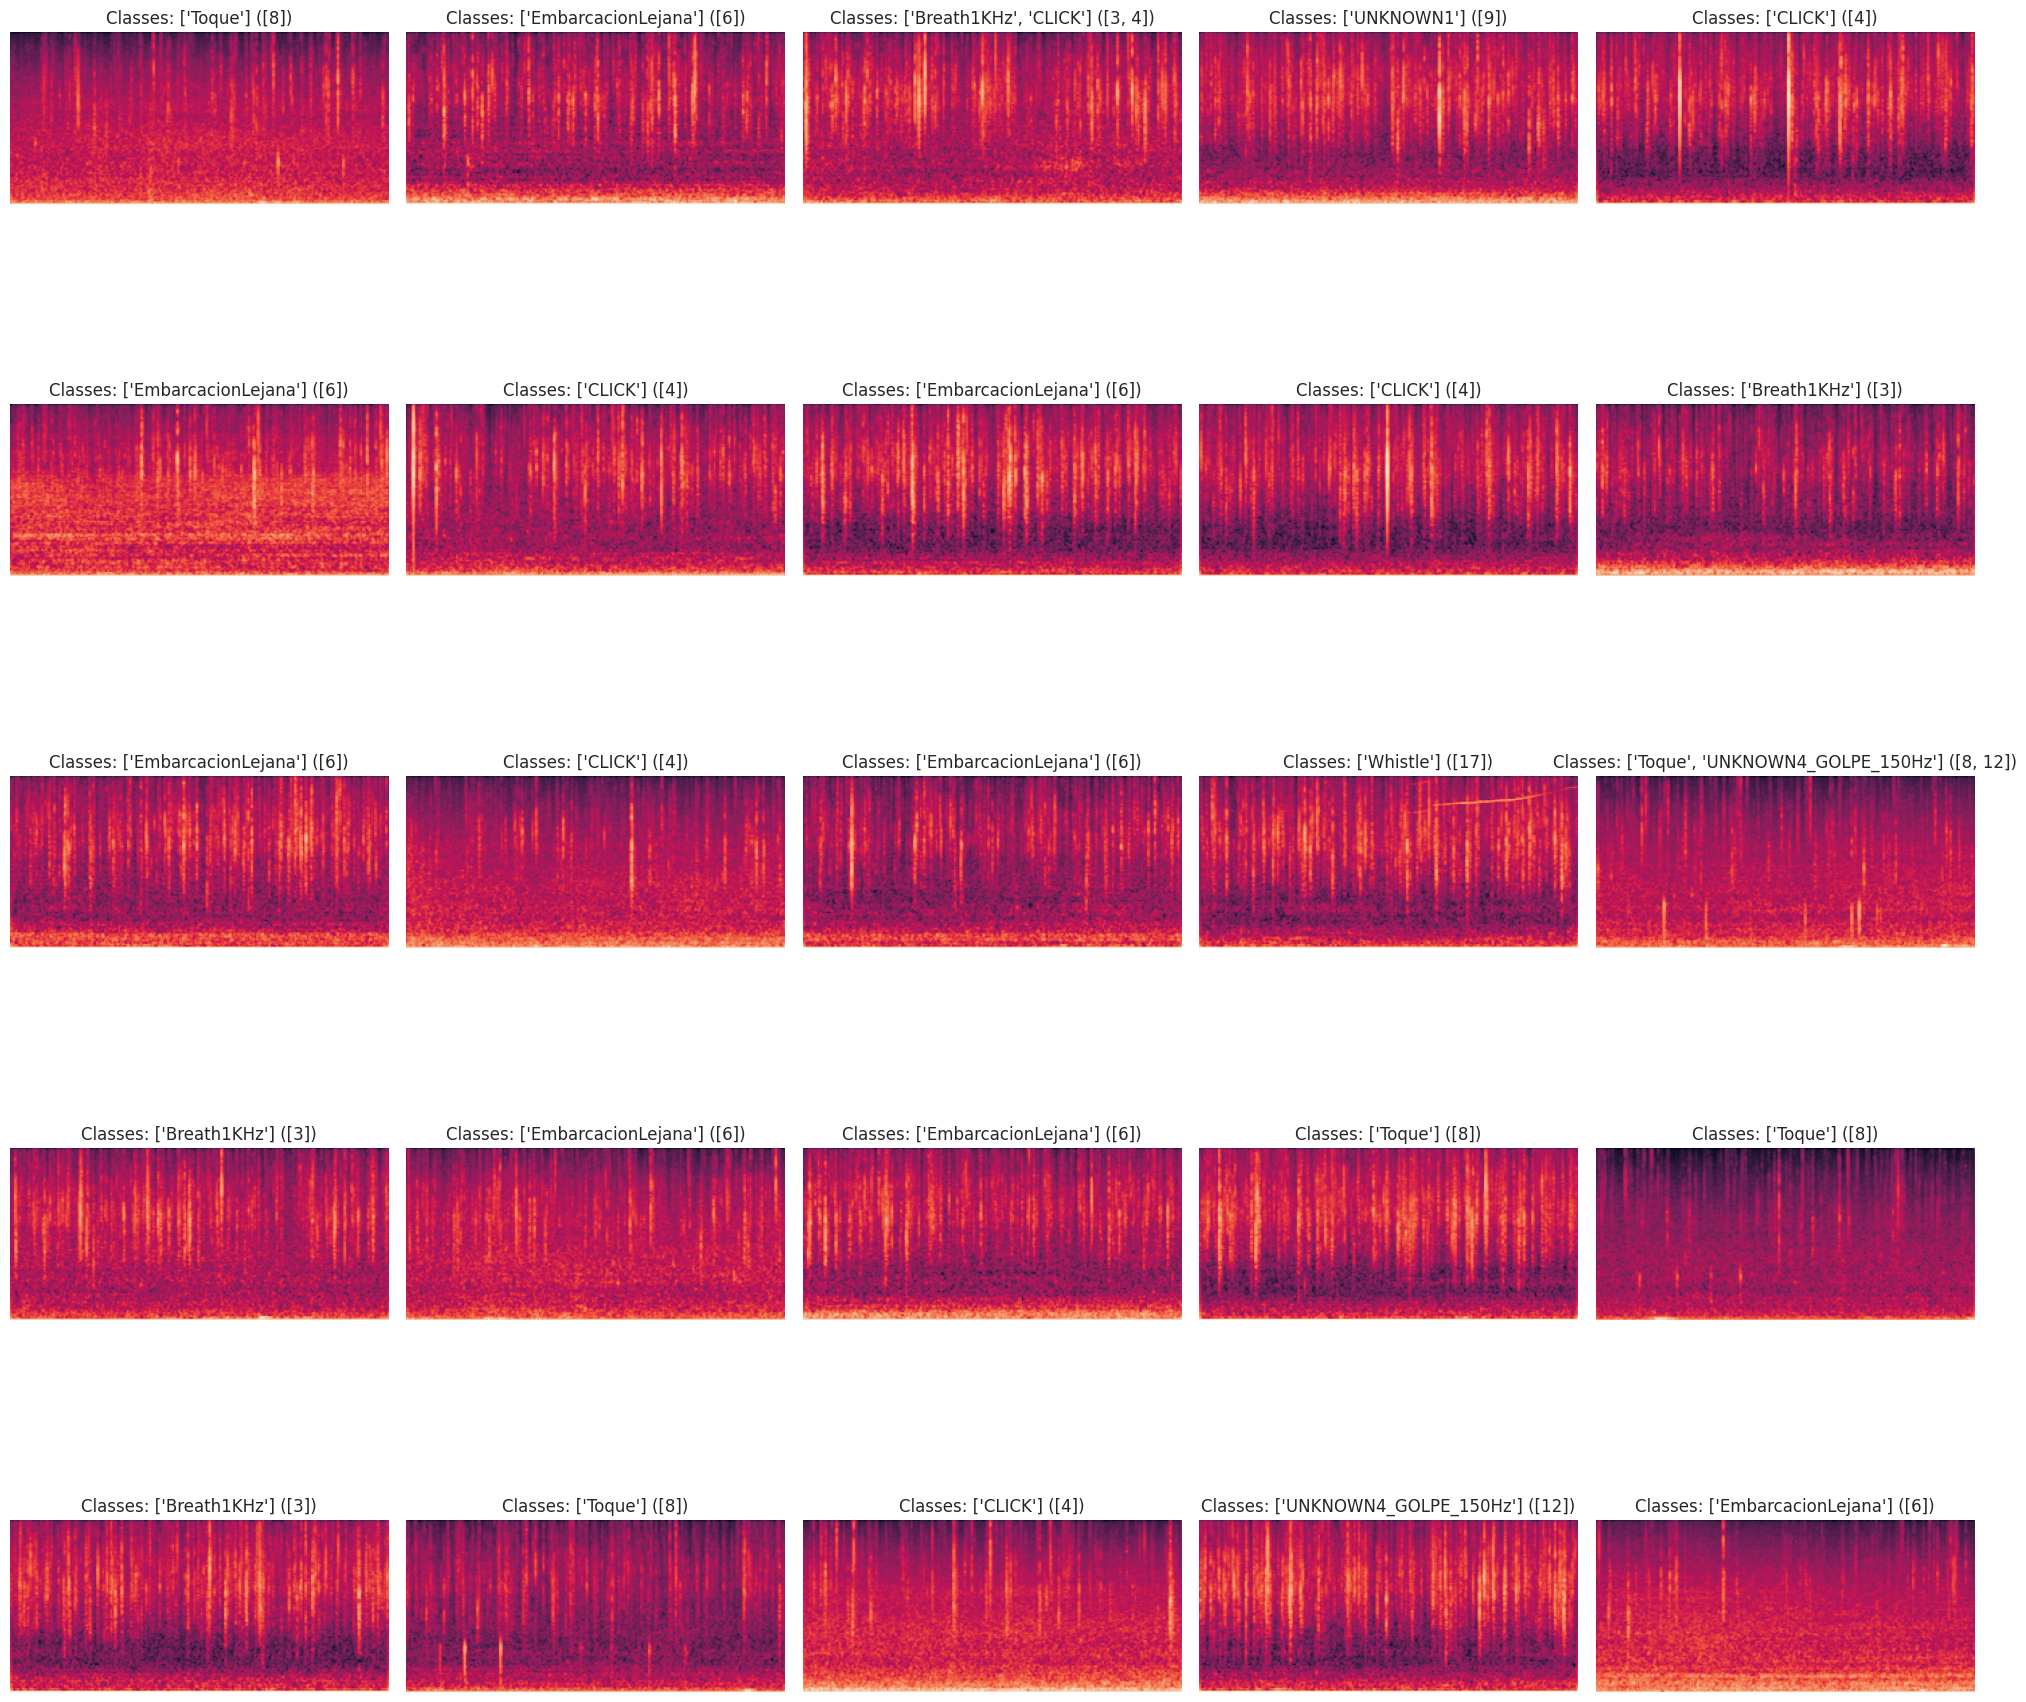

In [100]:
# Dataset path
DatasetPath = '../../Dataset/Audios/SEANIMALMOVE/SegmentedAudiosMultiLabel3/'

# Select 25 random samples from the training set that classes are not empty
random_samples = df_train[df_train['NumClasses'] > 0].sample(25, random_state=42)

# Create a grid of plots (5x5)
fig, axes = plt.subplots(5, 5, figsize=(20, 20))

# Flatten the axes
axes = axes.ravel()

for i, (_, row) in enumerate(random_samples.iterrows()):
    # Load the audio file and preprocess
    file_path = row['SegmentPath']
    processed_audio = preprocess_audio(file_path, DatasetPath, target_sr=48000, duration=3)
    
    # Calculate the mel spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=processed_audio, sr=48000)
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    
    # Handle class labels (this assumes it's multi-label)
    class_list = row['Class']  # If it's a list of classes
    # Plot the mel spectrogram
    axes[i].imshow(mel_spectrogram, origin='lower')
    # Add class label(s) to the title and its idx(s) in the mapping
    axes[i].set_title(f"Classes: {class_list} ({[CLASSES_MAPPING[classe] for classe in class_list]})")
    axes[i].axis('off')  # Hide axes

plt.tight_layout()
plt.show()

# Data Generators

## Data Augmentation

In [101]:
from pydub import AudioSegment

def add_noise(signal, noise_factor=0.005):
    noise = np.random.randn(len(signal))
    augmented_signal = signal + noise_factor * noise
    return augmented_signal

def shift_time(signal, shift_max=0.4):
    shift = np.random.randint(int(shift_max * len(signal)))
    augmented_signal = np.roll(signal, shift)
    return augmented_signal

# Mix Up
def mix_up(signal1, signal2, alpha=0.5):
    mixed_signal = alpha * signal1 + (1 - alpha) * signal2
    return mixed_signal

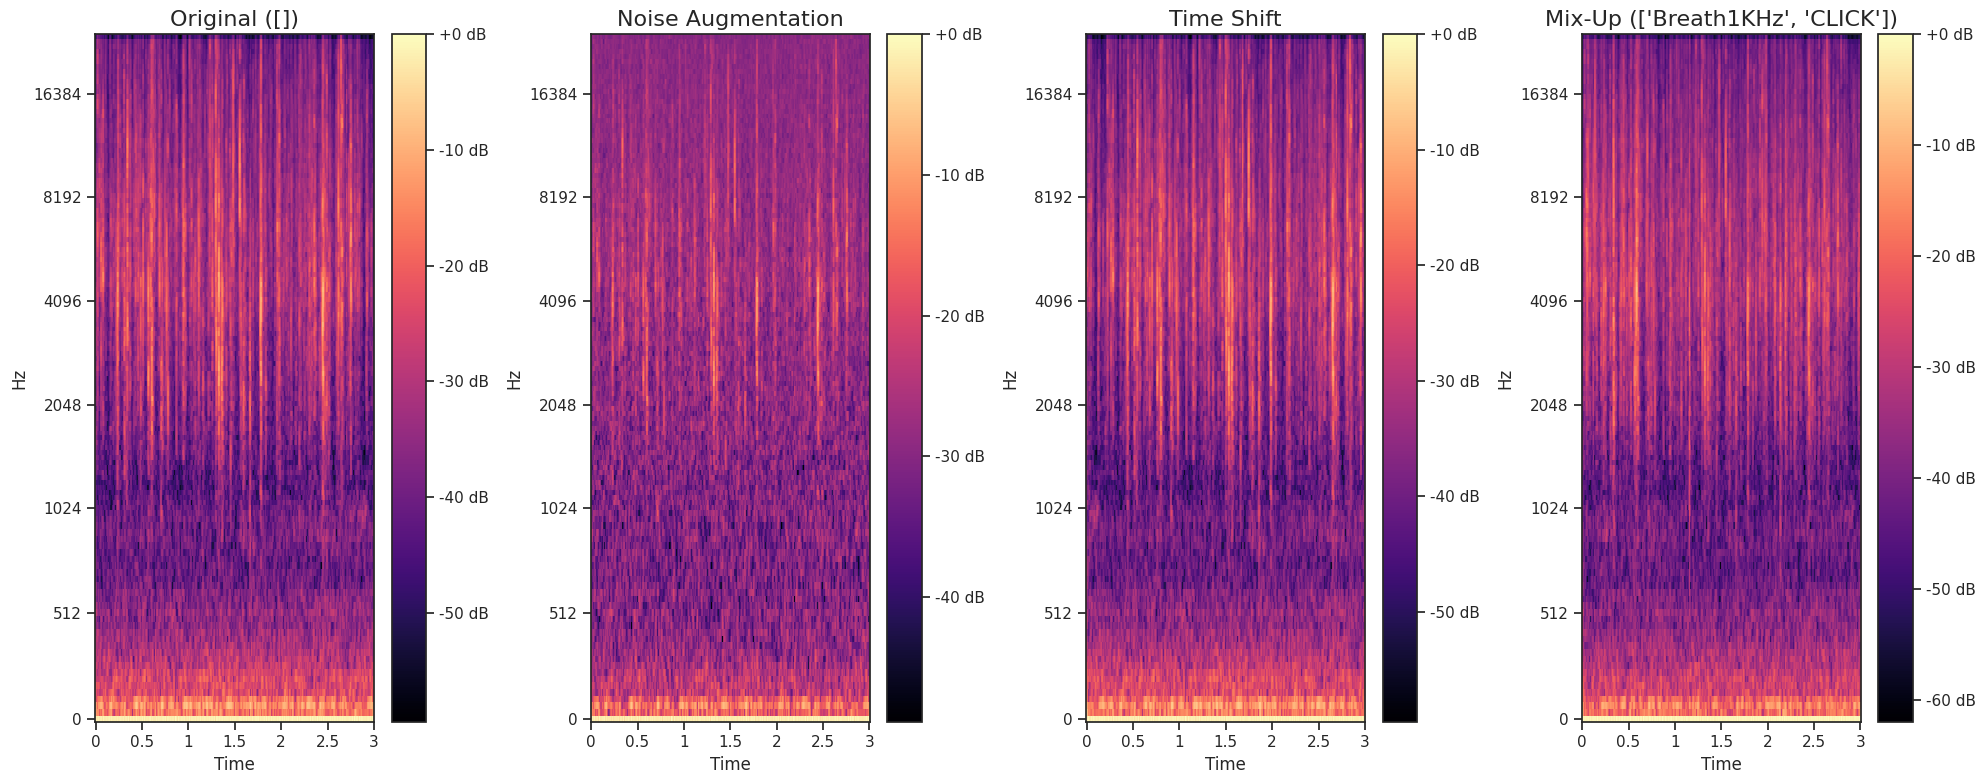

In [102]:
# Check data augmentation in the same audio, plot the original and the augmented audio with each of the changes
# Load the audio files
DatasetPath = '../../Dataset/Audios/SEANIMALMOVE/SegmentedAudiosMultiLabel3/'
sample_file = df_train['SegmentPath'][0]  # Assuming 'SegmentPath' is the column for file paths
sample_file_1 = df_train['SegmentPath'][1]
sample_file = os.path.join(DatasetPath, sample_file)
sample_file_1 = os.path.join(DatasetPath, sample_file_1)
signal, sr = librosa.load(sample_file, sr=48000)
signal_1, sr_1 = librosa.load(sample_file_1, sr=48000)

# Preprocess the audio (this ensures the signal is correctly padded or split)
signal = preprocess_audio(sample_file, target_sr=48000, duration=3)
signal_1 = preprocess_audio(sample_file_1, target_sr=48000, duration=3)

# Add noise
augmented_signal_noise = add_noise(signal, noise_factor=0.001)

# Shift time
augmented_signal_shift = shift_time(signal, shift_max=0.2)

# Mix up
augmented_signal_mix_up = mix_up(signal, signal_1, alpha=0.5)

# Mel spectrograms
mel_spectrogram = librosa.feature.melspectrogram(y=signal, sr=48000)
mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

mel_spectrogram_noise = librosa.feature.melspectrogram(y=augmented_signal_noise, sr=48000)
mel_spectrogram_noise = librosa.power_to_db(mel_spectrogram_noise, ref=np.max)

mel_spectrogram_shift = librosa.feature.melspectrogram(y=augmented_signal_shift, sr=48000)
mel_spectrogram_shift = librosa.power_to_db(mel_spectrogram_shift, ref=np.max)

mel_spectrogram_mix_up = librosa.feature.melspectrogram(y=augmented_signal_mix_up, sr=48000)
mel_spectrogram_mix_up = librosa.power_to_db(mel_spectrogram_mix_up, ref=np.max)

# Visualize mel spectrograms
plt.figure(figsize=(20, 8))

# Original audio
plt.subplot(1, 4, 1)
librosa.display.specshow(mel_spectrogram, sr=48000, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title(f'Original ({df_train["Class"][0]})', fontsize=16)
plt.tight_layout()

# Noise-added audio
plt.subplot(1, 4, 2)
librosa.display.specshow(mel_spectrogram_noise, sr=48000, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Noise Augmentation', fontsize=16)
plt.tight_layout()

# Time-shifted audio
plt.subplot(1, 4, 3)
librosa.display.specshow(mel_spectrogram_shift, sr=48000, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Time Shift', fontsize=16)
plt.tight_layout()

# Mix-up audio
plt.subplot(1, 4, 4)
librosa.display.specshow(mel_spectrogram_mix_up, sr=48000, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title(f'Mix-Up ({df_train["Class"][1]})', fontsize=16)
plt.tight_layout()

plt.show()

In [103]:
from keras.utils import to_categorical
import numpy as np
import librosa

# Function to generate audio data for training with augmentation (for multilabel classification)
def audio_data_generator(df, classes, classes_mapping, DatasetPath = "", batch_size=32, target_sr=48000, duration=3, augment=False):
    while True:
        X, y = [], []
        Segment_Path = []
        for _, row in df.iterrows():
            file_path = row['SegmentPath']
            cls_list = row['Class']  # Expecting this to be a list of class labels for multilabel
            # print(cls_list)
            cls_idx = [classes_mapping[cls] for cls in cls_list]  # Convert class labels to indices
            cls_vector = np.zeros(len(classes))  # Create a binary vector for multilabel
            
            # Set 1 for the classes that are present
            for idx in cls_idx:
                cls_vector[idx] = 1
            
            # Load and preprocess the audio
            signal = preprocess_audio(file_path, DatasetPath, target_sr, duration)

            if augment:
                if np.random.rand() < 0.5: # Add noise
                    signal = add_noise(signal)
                if np.random.rand() < 0.5: # Shift time
                    signal = shift_time(signal)
                if np.random.rand() < 0.5: # MixUp
                    # Apply MixUp between current signal and a random one from the dataset (Background?)
                    random_idx = np.random.randint(0, len(df))
                    signal_1 = preprocess_audio(df['SegmentPath'][random_idx], DatasetPath, target_sr=48000, duration=3)[0]
                    signal = mix_up(signal, signal_1, alpha=0.5)
                    cls_list_1 = df['Class'][random_idx]
                    cls_idx_1 = [classes_mapping[cls] for cls in cls_list_1]
                    # print(cls_list_1)
                    for idx in cls_idx_1:
                        cls_vector[idx] = 1
            
            # print("??????????????????????????")
                
            X.append(signal)
            # make all elements of cls_vector are integers and not float
            cls_vector = cls_vector.astype(int)

            y.append(cls_vector)  # Append the multilabel vector for the current signal
            Segment_Path.append(file_path)
                
            # If batch size is reached, yield the batch
            if len(X) == batch_size:
                X = np.array(X)
                y = np.array(y)
                Segment_Path = np.array(Segment_Path)
                yield X, y#, Segment_Path
                X, y = [], []  # Reset for next batch
                Segment_Path = []

# Example usage of the generator for the test dataset
DatasetPath = '../../Dataset/Audios/SEANIMALMOVE/SegmentedAudiosMultiLabel3/'
# take df with num_clases > 0
test_gen = audio_data_generator(df_test[df_test['NumClasses'] > 0].reset_index(drop=True), CLASSES, CLASSES_MAPPING, DatasetPath, batch_size=8, target_sr=48000, duration=3, augment=False)
X, y = next(test_gen)
print(X.shape, y.shape)  # Check the shape of the generated batch

(8, 144000) (8, 18)


In [104]:
# Put in same df X, y and Segment_Path
df_test_gen = pd.DataFrame()
# df_test_gen['SegmentPath'] = Segment_Path
df_test_gen['Signal'] = [signal.flatten() for signal in X]
df_test_gen['Class'] = [list(classes) for classes in y]

# Add column Class_name with the name of the classes in the Class column for CLASS_MAPPING
df_test_gen['Class_name'] = df_test_gen['Class'].apply(lambda x: [REVERSE_CLASSES_MAPPING[i] for i, v in enumerate(x) if v == 1])

In [105]:
df_test_gen

Signal  \
0  [-0.0009863011, -0.0014418184, -0.0014546877, ...   
1  [-0.0011164019, -0.0022185515, -0.0019188863, ...   
2  [-0.0009832196, -0.0018914114, -0.002145284, -...   
3  [-0.0013327794, -0.001966427, -0.0016719216, -...   
4  [-0.0012200907, -0.0023740942, -0.0020837015, ...   
5  [-0.0010651306, -0.0022022529, -0.0017907313, ...   
6  [-0.00078202103, -0.0014830129, -0.0015415647,...   
7  [-0.0013100113, -0.0023492922, -0.0020361245, ...   

                                               Class    Class_name  
0  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  [Breath1KHz]  
1  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  [Breath1KHz]  
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...     [Whistle]  
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...     [Whistle]  
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...     [Whistle]  
5  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...     [Whistle]  
6  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...     [Whistle]  
7  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  [Breath1KHz]

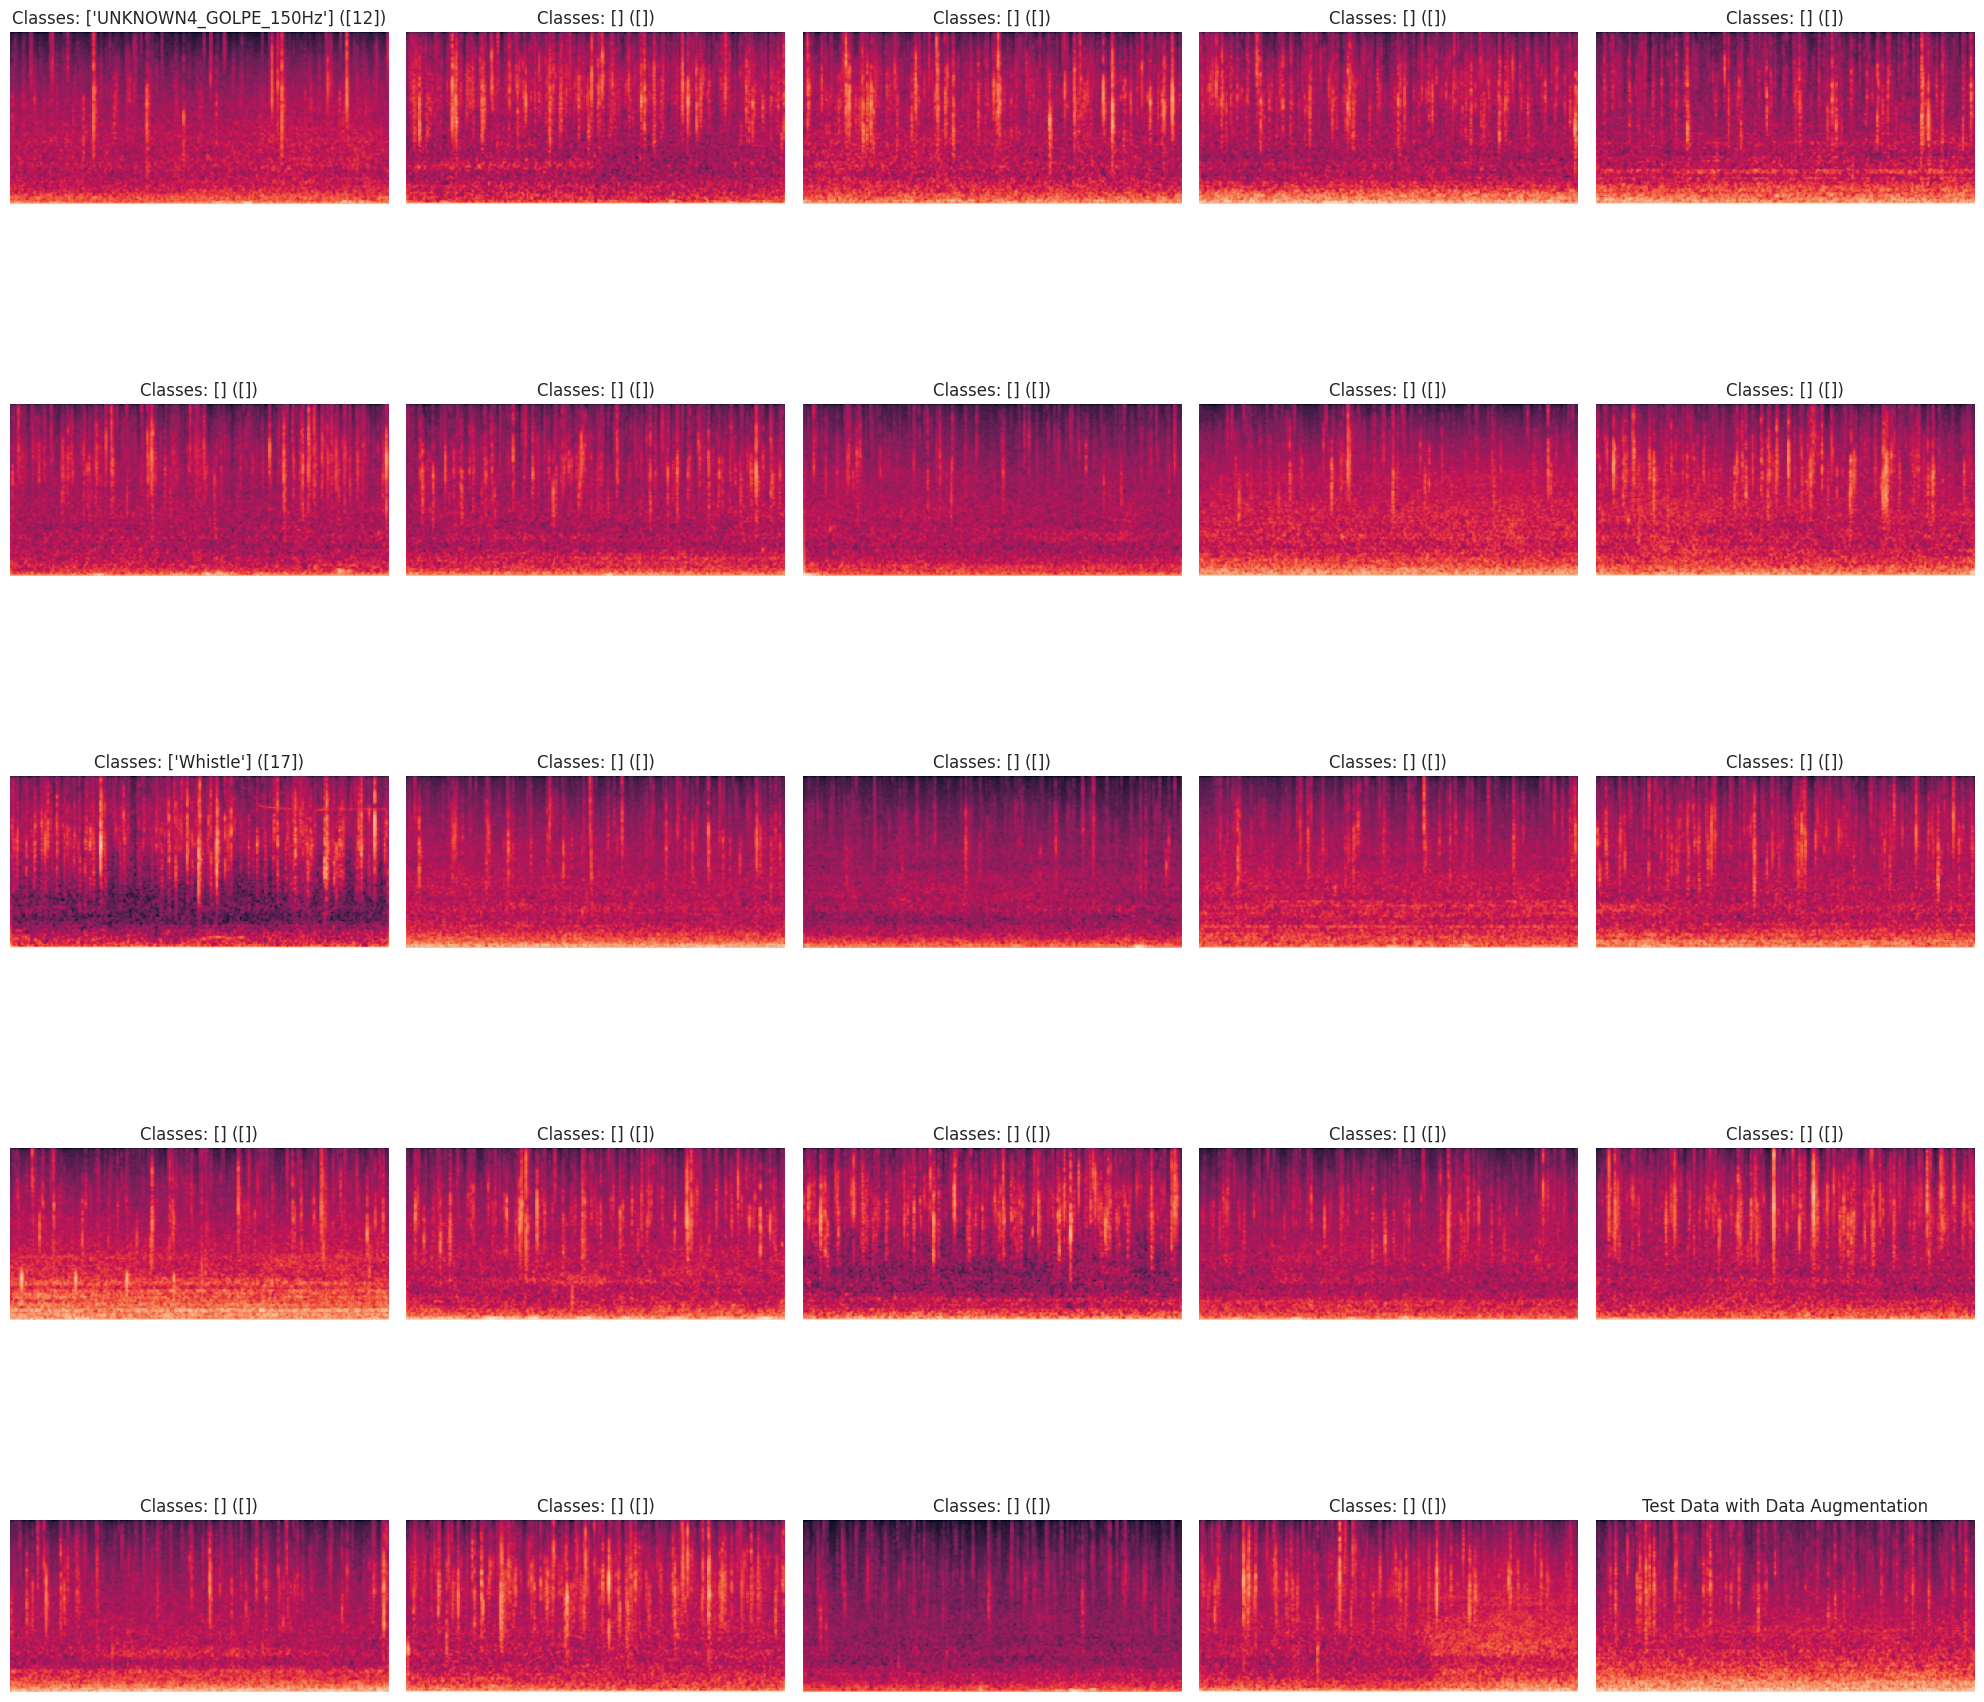

In [106]:
# Select 25 random samples
random_samples = df_test.sample(25, random_state=42)
DatasetPath = '../../Dataset/Audios/SEANIMALMOVE/SegmentedAudiosMultiLabel3/'

# Create a grid of plots
fig, axes = plt.subplots(5, 5, figsize=(20, 20))

# Flatten the axes
axes = axes.ravel()

# Loop through all the samples
for i, (_, row) in enumerate(random_samples.iterrows()):

    # preprocess the audio
    processed_audio = preprocess_audio(row['SegmentPath'], DatasetPath, target_sr=48000, duration=3)
    
    # Calculate the mel spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=processed_audio, sr=48000)
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    
    # Plot the mel spectrogram
    axes[i].imshow(mel_spectrogram, origin='lower')
    # Handle class labels (this assumes it's multi-label)
    classes = row['Class']  # If it's a list of classes
    # Add class label(s) to the title and its idx(s) in the mapping
    axes[i].set_title(f"Classes: {classes} ({[CLASSES_MAPPING[classe] for classe in classes]})")
    axes[i].axis('off')

plt.tight_layout()
plt.title('Test Data with Data Augmentation')
plt.show()

# Model Functions

In [107]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import multilabel_confusion_matrix

def load_base_model(model_path = 'BirdNET-Analyzer-V2.4/V2.4/BirdNET_GLOBAL_6K_V2.4_Model/', classes=CLASSES, freeze = True, n_freeze = 4, activation="softmax"):
    model = tf.keras.models.load_model(model_path, compile=False).model

    # Get the output of the second to last layer
    output_layer = model.layers[-2].output

    # Add 3 dense layers: 512, 128 and len(classes)

    # Add a dense layer with 512 units and ReLU activation
    x = tf.keras.layers.Dense(512, activation='relu')(output_layer)

    # Add a dense layer with 128 units and ReLU activation
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    # Add a dense layer with the number of classes and softmax activation
    output_layer = tf.keras.layers.Dense(len(classes), activation=activation, name = "output")(x) # sigmoid for binary classification - multilabel

    # output_layer = tf.keras.layers.Dense(len(classes), activation='softmax')(model.output)

    # Create a new model
    model = tf.keras.models.Model(inputs=model.input, outputs=output_layer)

    # Compile
    # model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'AUC', 'Precision', 'Recall', 'Sensitivity', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives', 'CategoricalAccuracy', 'F1Score'])

    if freeze:
        # Freeze first layers
        for layer in model.layers[:-n_freeze]:
            layer.trainable = False

    print(model.summary())

    return model

def model_compile(model, optimizer = "adam", loss = "categorical_crossentropy", metrics = ['accuracy']):
    # Compile
    model.compile(
        optimizer=optimizer, 
        loss=loss, 
        metrics=metrics
        ) 
    
    return model

def train_model(model, df_train, df_val, classes, classes_mapping, DatasetPath="", batch_size=8, target_sr=48000, duration=3, epochs=100, callbacks=None, doshuffle=True, dougmentation=False):
    # Training and Validation Generators

    # shuffle data
    if doshuffle:
        df_train = shuffle(df_train, random_state=42)
        df_val = shuffle(df_val, random_state=42)

    train_gen = audio_data_generator(df_train, classes, classes_mapping, DatasetPath, batch_size=batch_size, target_sr=target_sr, duration=duration, augment=dougmentation)
    val_gen = audio_data_generator(df_val, classes, classes_mapping, DatasetPath, batch_size=batch_size, target_sr=target_sr, duration=duration, augment=False)

    # Calculate steps per epoch and validation steps
    steps_per_epoch = len(df_train) // batch_size
    validation_steps = len(df_val) // batch_size

    # Train the model
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        shuffle=doshuffle,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )

    return model, history

def plot_training_monitoring(history):
    # Plot accuracy and loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(history.history['macro_f1'], label='Train Macro F1')
    plt.plot(history.history['val_macro_f1'], label='Val Macro F1')
    plt.legend()
    plt.title("Macro F1")

    plt.subplot(1, 3, 2)
    plt.plot(history.history['micro_f1'], label='Train Micro F1')
    plt.plot(history.history['val_micro_f1'], label='Val Micro F1')
    plt.legend()
    plt.title("Micro F1")

    plt.subplot(1, 3, 3)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title("Loss")

    plt.show()

def evaluate_model(model, df_test, threshold=0.5, classes=CLASSES, classes_mapping=CLASSES_MAPPING, DatasetPath="", batch_size=1, target_sr=48000, duration=3):
    test_gen = audio_data_generator(df_test, classes, classes_mapping, DatasetPath, batch_size=batch_size, augment=False)
    test_steps = len(df_test) // batch_size

    results = model.evaluate(test_gen, steps=test_steps)
    print(f"Test Loss: {results[0]}, Test Metrics: {results[1:]}")

    # Predict for all samples
    X_eval, y_true, y_pred = [], [], []
    for _ in range(test_steps):
        X_batch, y_batch = next(test_gen)
        y_pred_batch = model.predict(X_batch, batch_size=batch_size, verbose=0)
        X_eval.append(X_batch)
        y_true.append(y_batch)
        y_pred.append(y_pred_batch)

    # Apply threshold to predictions for multilabel
    y_pred = np.array(y_pred)
    y_pred_binary = (y_pred > threshold).astype(int)

    # Flatten y_true and y_pred_binary
    y_true_flat = [item.astype(int) for sublist in y_true for item in sublist]
    y_pred_binary_flat = [item for sublist in y_pred_binary for item in sublist]

    # Generate DataFrame for results
    df_results = pd.DataFrame({
        'Signal': [item for sublist in X_eval for item in sublist],
        'True': y_true_flat,
        'Predicted': y_pred_binary_flat,
        'Confidence': [item for sublist in y_pred for item in sublist]
        })
    
    return df_results


# Experiment 0: Base Multilabel

In [108]:
from private_credentials import API_COMETML
experiment = start(
  api_key=API_COMETML,
  project_name="Cetaceans",
  workspace="gruncrow",
)

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.


COMET INFO: Experiment is live on comet.com https://www.comet.com/gruncrow/cetaceans/c5208ac7656e4802ad16f5d9b3d04500



## Load and compile model

In [109]:
import tensorflow as tf

@tf.function
def macro_f1(y_true, y_pred, thresh=0.3):
    y_pred = tf.cast(y_pred > thresh, tf.float32)
    tp = tf.reduce_sum(y_true * y_pred, axis=0)
    fp = tf.reduce_sum(y_pred * (1 - y_true), axis=0)
    fn = tf.reduce_sum((1 - y_pred) * y_true, axis=0)
    f1 = 2 * tp / (2 * tp + fp + fn + 1e-8)
    macro_f1 = tf.reduce_mean(f1)  # Promedia sobre todas las etiquetas
    return macro_f1

@tf.function
def micro_f1(y_true, y_pred, thresh=0.3):
    y_pred = tf.cast(y_pred > thresh, tf.float32)
    tp = tf.reduce_sum(y_true * y_pred)
    fp = tf.reduce_sum(y_pred * (1 - y_true))
    fn = tf.reduce_sum((1 - y_pred) * y_true)
    f1 = 2 * tp / (2 * tp + fp + fn + 1e-8)
    return f1

Accuracy is missleading when dealing with multi label classification. In other words , having an accuracy near to 1 doesn't mean your model is doing well because when you have many zeros , these labels dominate the accuracy: suppose for example that your output is of shape 20, if 17 of these 20 outputs are Zeros, in the worst case if you are having wrong results in the 3 remaining outputs , your accuracy is going to be 17/20 , which is very near to one , still your model is not good because it gives wrong results for the three usefull outputs. Use your own metric , so using tensorflow is more flexible : I myself wanted to do it with Keras by creating my own metric but I got results that don't satisfy me at all because Keras is doing some backend calculations that I can't track, which is not the case if you use immediately Tensorflow because you built everything from scratch and have in fact more visibility within your code , and thus could control everything. I advise you to use precision and recall for each output independently ( that part really sucks if you try to do it in Keras, well I couldn't do it ) .
Second point to specify, make sure that your input data is normalized: because otherwise you may have an overflow issue, and your gradient will be stack , and you'll get constant results all the time ( for example constant accuracy or whatever thing you are calculating). Hope it helps , good luck.

In [110]:
import tensorflow_addons as tfa
focal_loss = tfa.losses.SigmoidFocalCrossEntropy()

EXPERIMENT = "0_SEANIMALMOVE_Multilabel"

OPTIMIZER = "adam"
ACTIVATION = "sigmoid"
LOSS = focal_loss #"binary_crossentropy"
METRICS = [macro_f1, micro_f1] # ['binary_accuracy'] #[tf.keras.metrics.AUC(multi_label=True)] #['accuracy'] # , 'AUC', 'Precision', 'Recall', 'Sensitivity', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives', 'CategoricalAccuracy', 'F1Score'

BATCH_SIZE = 16
EPOCHS = 100
SHUFFLE = True

# Callbacks
CALLBACKS = [
    ModelCheckpoint(f"Models/{EXPERIMENT}/best_model.h5", save_best_only=True, monitor="val_micro_f1", mode="max", verbose=1),
    EarlyStopping(patience=10, restore_best_weights=True, monitor="val_micro_f1", mode="max", verbose=1),
    CSVLogger(f"Models/{EXPERIMENT}/training_log.csv", append=True),
    LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20)),  # Adjust growth rate as needed
    ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min")
]

In [111]:
model = load_base_model(activation=ACTIVATION)
model = model_compile(model, optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 INPUT (InputLayer)          [(None, 144000)]             0         []                            
                                                                                                  
 MEL_SPEC1 (MelSpecLayerSim  (None, 96, 511, 1)           1         ['INPUT[0][0]']               
 ple)                                                                                             
                                                                                                  
 MEL_SPEC2 (MelSpecLayerSim  (None, 96, 511, 1)           1         ['INPUT[0][0]']               
 ple)                                                                                             
                                                                                            

## Train Model

In [112]:
# # check in df train how many samples of empty class are present and how many of non-empty class
# empty_class = df_train[df_train['NumClasses'] == 0]
# non_empty_class = df_train[df_train['NumClasses'] > 0]

# print(f"Empty Class: {len(empty_class)}")
# print(f"Non Empty Class: {len(non_empty_class)}")

# # take only 1500 random samples of empty class and all of non-empty class
# empty_class = empty_class.sample(100, random_state=42)
# undersampled_df_train = pd.concat([empty_class, non_empty_class])

# # check in df train how many samples of empty class are present and how many of non-empty class
# empty_class = df_val[df_val['NumClasses'] == 0]
# non_empty_class = df_val[df_val['NumClasses'] > 0]

# print(f"Empty Class: {len(empty_class)}")
# print(f"Non Empty Class: {len(non_empty_class)}")

# # take only 500 random samples of empty class and all of non-empty class
# empty_class = empty_class.sample(50, random_state=42)
# undersampled_df_val = pd.concat([empty_class, non_empty_class])

In [113]:
# # check in df train how many samples of empty class are present and how many of non-empty class
# empty_class = undersampled_df_train[undersampled_df_train['NumClasses'] == 0]
# non_empty_class = undersampled_df_train[undersampled_df_train['NumClasses'] > 0]

# print(f"Empty Class: {len(empty_class)}")
# print(f"Non Empty Class: {len(non_empty_class)}")

# # check in df val how many samples of empty class are present and how many of non-empty class
# empty_class = undersampled_df_val[undersampled_df_val['NumClasses'] == 0]
# non_empty_class = undersampled_df_val[undersampled_df_val['NumClasses'] > 0]

# print(f"Empty Class: {len(empty_class)}")
# print(f"Non Empty Class: {len(non_empty_class)}")

In [114]:
# train_gen = audio_data_generator(df_train, classes, classes_mapping, DatasetPath, batch_size=8, augment=False)
# X_train, y_train = next(train_gen)
# print(X_train[i], y_train_bin[i])

How sparse are the labels? I am guessing they are mostly 0s with a few 1s. In that case, the model can reach high accuracy on sparse labels by always guessing 0s. In the loss function, you should use a weighting on the positive labels on the order of sqrt(num labels) has worked well for me in the past (you will need to tune this).

Tensorflow has such a primitive built in: https://www.tensorflow.org/api_docs/python/tf/nn/weighted_cross_entropy_with_logits

In [ ]:
DatasetPath = '../../Dataset/Audios/SEANIMALMOVE/SegmentedAudiosMultiLabel3/'
BATCH_SIZE = 32
model, history = train_model(model, df_train, df_val, CLASSES, CLASSES_MAPPING, DatasetPath=DatasetPath, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=CALLBACKS, doshuffle=SHUFFLE)

Epoch 1/100
1257/1257 [==============================] - ETA: 0s - loss: 0.0412 - macro_f1: 0.0049 - micro_f1: 0.0658


Epoch 1: val_micro_f1 improved from -inf to 0.13930, saving model to Models/0_SEANIMALMOVE_Multilabel/best_model.h5
1257/1257 [==============================] - 1048s 830ms/step - loss: 0.0412 - macro_f1: 0.0049 - micro_f1: 0.0658 - val_loss: 0.0258 - val_macro_f1: 0.0095 - val_micro_f1: 0.1393 - lr: 1.0000e-04
Epoch 2/100
  15/1257 [..............................] - ETA: 13:52 - loss: 0.0217 - macro_f1: 0.0037 - micro_f1: 0.0267

  89/1257 [=>............................] - ETA: 13:06 - loss: 0.0219 - macro_f1: 0.0080 - micro_f1: 0.1045

 466/1257 [==========>...................] - ETA: 8:59 - loss: 0.0209 - macro_f1: 0.0099 - micro_f1: 0.1173

KeyboardInterrupt: 

: 

In [ ]:
experiment.end()

In [ ]:
model.save(f"Models/{EXPERIMENT}/")

INFO:tensorflow:Assets written to: Models/0_SEANIMALMOVE_Multilabel/assets


INFO:tensorflow:Assets written to: Models/0_SEANIMALMOVE_Multilabel/assets


## Monitor Training

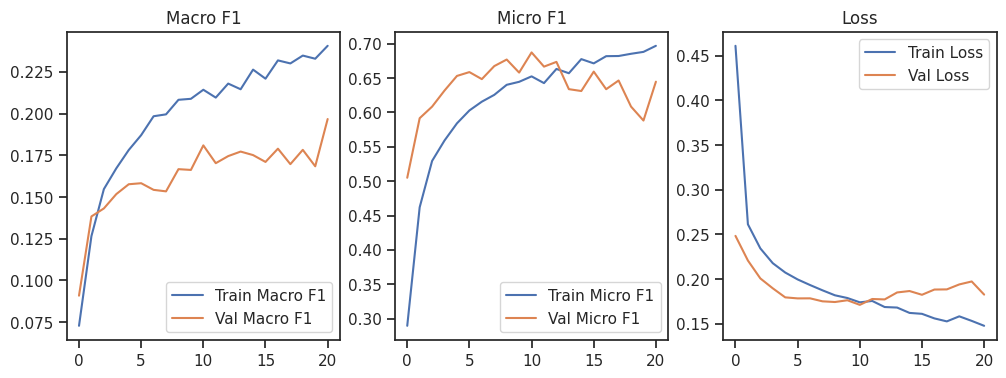

In [ ]:
plot_training_monitoring(history)

In [96]:
# Load model
model = tf.keras.models.load_model(f"Models/{EXPERIMENT}/")

ValueError: Unable to restore custom object of class "MeanMetricWrapper" (type _tf_keras_metric). Please make sure that this class is included in the `custom_objects` arg when calling `load_model()`. Also, check that the class implements `get_config` and `from_config`.

Complete metadata: {'class_name': 'MeanMetricWrapper', 'name': 'macro_f1', 'dtype': 'float32', 'config': {'name': 'macro_f1', 'dtype': 'float32'}, 'shared_object_id': 551}

## Evaluate Model

In [76]:
TEST_BATCH_SIZE = 16

df_results = evaluate_model(model, df_test, 0.1, CLASSES, CLASSES_MAPPING, DatasetPath, batch_size=TEST_BATCH_SIZE)

545/545 [==============================] - 150s 276ms/step - loss: 0.1429 - macro_f1: 0.0036 - micro_f1: 0.0281
Test Loss: 0.14286287128925323, Test Metrics: [0.003599111456423998, 0.028130488470196724]


In [77]:
from sklearn.metrics import f1_score, precision_score, recall_score, zero_one_loss, accuracy_score, hamming_loss

y_true = df_results['True']
y_pred = df_results['Predicted']

# Convert y_true and y_pred to numpy arrays
y_true_np = np.array(y_true.tolist())
y_pred_np = np.array(y_pred.tolist())

accuracy = accuracy_score(y_true_np, y_pred_np)
macro_f1 = f1_score(y_true_np, y_pred_np, average='macro')
micro_f1 = f1_score(y_true_np, y_pred_np, average='micro')
precision = precision_score(y_true_np, y_pred_np, average='macro')
recall = recall_score(y_true_np, y_pred_np, average='macro')
ze_one_loss = zero_one_loss(y_true_np, y_pred_np)
hamm_loss = hamming_loss(y_true_np, y_pred_np)

print(f"Accuracy: {accuracy}")
print(f"Macro F1: {macro_f1}")
print(f"Micro F1: {micro_f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Zero One Loss: {ze_one_loss}")
print(f"Hamming Loss: {hamm_loss}")

Accuracy: 0.004128440366972477
Macro F1: 0.009075726159466451
Micro F1: 0.011057667619520378
Precision: 0.004594205265867886
Recall: 0.5770022158911048
Zero One Loss: 0.9958715596330275
Hamming Loss: 0.3680874108053007


In [78]:
TEST_BATCH_SIZE = 16

df_results = evaluate_model(model, df_test, 0.3, CLASSES, CLASSES_MAPPING, DatasetPath, batch_size=TEST_BATCH_SIZE)

545/545 [==============================] - 167s 307ms/step - loss: 0.1429 - macro_f1: 0.0036 - micro_f1: 0.0281
Test Loss: 0.14286287128925323, Test Metrics: [0.003599111456423998, 0.028130488470196724]


In [79]:
from sklearn.metrics import f1_score, precision_score, recall_score, zero_one_loss, accuracy_score, hamming_loss

y_true = df_results['True']
y_pred = df_results['Predicted']

# Convert y_true and y_pred to numpy arrays
y_true_np = np.array(y_true.tolist())
y_pred_np = np.array(y_pred.tolist())

accuracy = accuracy_score(y_true_np, y_pred_np)
macro_f1 = f1_score(y_true_np, y_pred_np, average='macro')
micro_f1 = f1_score(y_true_np, y_pred_np, average='micro')
precision = precision_score(y_true_np, y_pred_np, average='macro')
recall = recall_score(y_true_np, y_pred_np, average='macro')
ze_one_loss = zero_one_loss(y_true_np, y_pred_np)
hamm_loss = hamming_loss(y_true_np, y_pred_np)

print(f"Accuracy: {accuracy}")
print(f"Macro F1: {macro_f1}")
print(f"Micro F1: {micro_f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Zero One Loss: {ze_one_loss}")
print(f"Hamming Loss: {hamm_loss}")

Accuracy: 0.08887614678899082
Macro F1: 0.03408379929215731
Micro F1: 0.043321948588890886
Precision: 0.02007466567115122
Recall: 0.2728404020856851
Zero One Loss: 0.9111238532110092
Hamming Loss: 0.06781345565749236


In [80]:
TEST_BATCH_SIZE = 16

df_results = evaluate_model(model, df_test, 0.5, CLASSES, CLASSES_MAPPING, DatasetPath, batch_size=TEST_BATCH_SIZE)

545/545 [==============================] - 154s 283ms/step - loss: 0.1429 - macro_f1: 0.0036 - micro_f1: 0.0281
Test Loss: 0.14286287128925323, Test Metrics: [0.003599111456423998, 0.028130488470196724]


In [81]:
from sklearn.metrics import f1_score, precision_score, recall_score, zero_one_loss, accuracy_score, hamming_loss

y_true = df_results['True']
y_pred = df_results['Predicted']

# Convert y_true and y_pred to numpy arrays
y_true_np = np.array(y_true.tolist())
y_pred_np = np.array(y_pred.tolist())

accuracy = accuracy_score(y_true_np, y_pred_np)
macro_f1 = f1_score(y_true_np, y_pred_np, average='macro')
micro_f1 = f1_score(y_true_np, y_pred_np, average='micro')
precision = precision_score(y_true_np, y_pred_np, average='macro')
recall = recall_score(y_true_np, y_pred_np, average='macro')
ze_one_loss = zero_one_loss(y_true_np, y_pred_np)
hamm_loss = hamming_loss(y_true_np, y_pred_np)

print(f"Accuracy: {accuracy}")
print(f"Macro F1: {macro_f1}")
print(f"Micro F1: {micro_f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Zero One Loss: {ze_one_loss}")
print(f"Hamming Loss: {hamm_loss}")

Accuracy: 0.7895642201834863
Macro F1: 0.0571177673711096
Micro F1: 0.1253507951356408
Precision: 0.09055340017652952
Recall: 0.12338562904600642
Zero One Loss: 0.21043577981651373
Hamming Loss: 0.011913863404689093


In [86]:
TEST_BATCH_SIZE = 16

df_results = evaluate_model(model, df_test, 0.7, CLASSES, CLASSES_MAPPING, DatasetPath, batch_size=TEST_BATCH_SIZE)

545/545 [==============================] - 155s 284ms/step - loss: 0.1429 - macro_f1: 0.0036 - micro_f1: 0.0281
Test Loss: 0.14286287128925323, Test Metrics: [0.003599111456423998, 0.028130488470196724]


In [87]:
from sklearn.metrics import f1_score, precision_score, recall_score, zero_one_loss, accuracy_score, hamming_loss

y_true = df_results['True']
y_pred = df_results['Predicted']

# Convert y_true and y_pred to numpy arrays
y_true_np = np.array(y_true.tolist())
y_pred_np = np.array(y_pred.tolist())

accuracy = accuracy_score(y_true_np, y_pred_np)
macro_f1 = f1_score(y_true_np, y_pred_np, average='macro')
micro_f1 = f1_score(y_true_np, y_pred_np, average='micro')
precision = precision_score(y_true_np, y_pred_np, average='macro')
recall = recall_score(y_true_np, y_pred_np, average='macro')
ze_one_loss = zero_one_loss(y_true_np, y_pred_np)
hamm_loss = hamming_loss(y_true_np, y_pred_np)

print(f"Accuracy: {accuracy}")
print(f"Macro F1: {macro_f1}")
print(f"Micro F1: {micro_f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Zero One Loss: {ze_one_loss}")
print(f"Hamming Loss: {hamm_loss}")

Accuracy: 0.9544724770642202
Macro F1: 0.04753041139433951
Micro F1: 0.26161790017211706
Precision: 0.04718702229427904
Recall: 0.05022461814914645
Zero One Loss: 0.045527522935779774
Hamming Loss: 0.0027331804281345564


In [84]:
TEST_BATCH_SIZE = 16

df_results = evaluate_model(model, df_test, 0.9, CLASSES, CLASSES_MAPPING, DatasetPath, batch_size=TEST_BATCH_SIZE)

545/545 [==============================] - 146s 268ms/step - loss: 0.1429 - macro_f1: 0.0036 - micro_f1: 0.0281
Test Loss: 0.14286287128925323, Test Metrics: [0.003599111456423998, 0.028130488470196724]


In [85]:
from sklearn.metrics import f1_score, precision_score, recall_score, zero_one_loss, accuracy_score, hamming_loss

y_true = df_results['True']
y_pred = df_results['Predicted']

# Convert y_true and y_pred to numpy arrays
y_true_np = np.array(y_true.tolist())
y_pred_np = np.array(y_pred.tolist())

accuracy = accuracy_score(y_true_np, y_pred_np)
macro_f1 = f1_score(y_true_np, y_pred_np, average='macro')
micro_f1 = f1_score(y_true_np, y_pred_np, average='micro')
precision = precision_score(y_true_np, y_pred_np, average='macro')
recall = recall_score(y_true_np, y_pred_np, average='macro')
ze_one_loss = zero_one_loss(y_true_np, y_pred_np)
hamm_loss = hamming_loss(y_true_np, y_pred_np)

print(f"Accuracy: {accuracy}")
print(f"Macro F1: {macro_f1}")
print(f"Micro F1: {micro_f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Zero One Loss: {ze_one_loss}")
print(f"Hamming Loss: {hamm_loss}")

Accuracy: 0.970756880733945
Macro F1: 0.03496115427302997
Micro F1: 0.22163588390501318
Precision: 0.07905982905982906
Recall: 0.02261904761904762
Zero One Loss: 0.02924311926605505
Hamming Loss: 0.001879459734964322
